In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torchvision
import torchvision.transforms as transforms

from hdf5_dataset import HDF5Dataset

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST preparation

In [2]:
# dataset preparation
def load_dataset(batch_size = 512, path = "/datax/scratch/zelakiewicz/"):
    dataset = HDF5Dataset(file_path=path , recursive=False, load_data=True, transform=transforms.ToTensor())

    train_dataset, test_dataset = random_split(dataset, [25000, 5000])
   
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    return train_loader, test_loader

# Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(128 * 128, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 50)
        )
        
    def forward(self, X):
        return self.layers(X)

# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(50 + 6, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 128),
            nn.Sigmoid()
        )
        
    def forward(self, z, c):
        zc = torch.cat([z, c], dim=1)
        return self.layers(zc)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(128 * 128 + 50 + 6, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,1),
            nn.Sigmoid()
        )
        
    def forward(self, X, z, c):
        Xzc = torch.cat([X, z, c], dim=1)
        return self.layers(Xzc)

# Discriminator loss

In [6]:
def D_loss(DG, DE, eps=1e-6):
    loss = torch.log(DE + eps) + torch.log(1 - DG + eps)
    return -torch.mean(loss)

# Encoder - Generator loss

In [7]:
def EG_loss(DG, DE, eps=1e-6):
    loss = torch.log(DG + eps) + torch.log(1 - DE + eps)
    return -torch.mean(loss)

# Weights initializer

In [8]:
def init_weights(Layer):
    name = Layer.__class__.__name__
    if name == 'Linear':
        torch.nn.init.normal_(Layer.weight, mean=0, std=0.02)
        if Layer.bias is not None:
            torch.nn.init.constant_(Layer.bias, 0)

# BiGAN preparation

In [9]:
n_epochs = 400
l_rate = 2e-5

E = Encoder().to(device)
G = Generator().to(device)
D = Discriminator().to(device)

E.apply(init_weights)
G.apply(init_weights)
D.apply(init_weights)

#optimizers with weight decay
optimizer_EG = torch.optim.Adam(list(E.parameters()) + list(G.parameters()), 
                                lr=l_rate, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_D = torch.optim.Adam(D.parameters(), 
                               lr=l_rate, betas=(0.5, 0.999), weight_decay=1e-5)

#optimizers without weight decay
# optimizer_EG = torch.optim.Adam(list(E.parameters()) + list(G.parameters()), lr=l_rate, betas=(0.5, 0.999))
# optimizer_D = torch.optim.Adam(D.parameters(), lr=l_rate, betas=(0.5, 0.999))

#learning rate scheduler
# lambda_ = lambda epoch: 1 if epoch < 300 else 0.978 ** (epoch-300)
# scheduler_EG = torch.optim.lr_scheduler.LambdaLR(optimizer_EG, lr_lambda=lambda_)
# scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_)

mnist_train, mnist_test = load_dataset()

/mnt_home/zelakiewicz/code/SETI-ML/hdf5_dataset.py:86: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  idx = self._add_to_cache(ds.value, file_path)
/mnt_home/zelakiewicz/code/SETI-ML/hdf5_dataset.py:91: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.data_info.append({'file_path': file_path, 'type': dname, 'shape': ds.value.shape, 'cache_idx': idx})


In [10]:
E_total_params = sum(p.numel() for p in E.parameters() if p.requires_grad)

D_total_params = sum(p.numel() for p in D.parameters() if p.requires_grad)

G_total_params = sum(p.numel() for p in G.parameters() if p.requires_grad)

total = E_total_params+D_total_params+G_total_params

print('E: ',E_total_params)
print('G: ',G_total_params)
print('D: ',D_total_params)
print('Total: ',total)

E:  17329714
G:  17350144
D:  8946177
Total:  43626035


In [11]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(E)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| layers.0.weight |  16777216  |
|  layers.0.bias  |    1024    |
| layers.2.weight |   524288   |
|  layers.2.bias  |    512     |
| layers.3.weight |    512     |
|  layers.3.bias  |    512     |
| layers.5.weight |   25600    |
|  layers.5.bias  |     50     |
+-----------------+------------+
Total Trainable Params: 17329714


17329714

# Training

In [12]:
for epoch in range(n_epochs):
    D_loss_acc = 0.
    EG_loss_acc = 0.
    D.train()
    E.train()
    G.train()
        
#     scheduler_D.step()
#     scheduler_EG.step()
    
    for i, (images, labels) in enumerate(tqdm(mnist_train)):
        images = images.to(device)
        images = images.reshape(images.size(0),-1)
        
        #make one-hot embedding from labels
        c = torch.zeros(images.size(0), 6, dtype=torch.float32).to(device)
        c[torch.arange(images.size(0)), labels] = 1
        
        #initialize z from 50-dim U[-1,1]
        z = torch.rand(images.size(0), 50)
        z = z.to(device)
        
        # Start with Discriminator Training
        optimizer_D.zero_grad()

        #compute G(z, c) and E(X)
        Gz = G(z, c)
        EX = E(images)
        
        #compute D(G(z, c), z, c) and D(X, E(X), c)
        DG = D(Gz, z, c)
        DE = D(images, EX, c)
        
        #compute losses
        loss_D = D_loss(DG, DE)
        D_loss_acc += loss_D.item()
        
        loss_D.backward(retain_graph=True)
        optimizer_D.step()

        #Encoder & Generator training
        optimizer_EG.zero_grad()
        
        #compute G(z, c) and E(X)
        Gz = G(z, c)
        EX = E(images)
        
        #compute D(G(z, c), z, c) and D(X, E(X), c)
        DG = D(Gz, z, c)
        DE = D(images, EX, c)
        
        #compute losses
        loss_EG = EG_loss(DG, DE)
        EG_loss_acc += loss_EG.item()

        loss_EG.backward()
        optimizer_EG.step()

    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Avg_Loss_D: {:.4f}, Avg_Loss_EG: {:.4f}'
              .format(epoch + 1, n_epochs, D_loss_acc / i, EG_loss_acc / i))
        n_show = 10
        D.eval()
        E.eval()
        G.eval()
        
        with torch.no_grad():
            #generate images from same class as real ones
            real = images[:n_show]
            c = torch.zeros(n_show, 6, dtype=torch.float32).to(device)
            c[torch.arange(n_show), labels[:n_show]] = 1
            z = torch.rand(n_show, 50)
            z = z.to(device)
            gener = G(z, c).reshape(n_show, 128, 128).cpu().numpy()
            recon = G(E(real), c).reshape(n_show, 128, 128).cpu().numpy()
            real = real.reshape(n_show, 128, 128).cpu().numpy()

            fig, ax = plt.subplots(3, n_show, figsize=(15,5))
            fig.subplots_adjust(wspace=0.05, hspace=0)
            plt.rcParams.update({'font.size': 20})
            fig.suptitle('Epoch {}'.format(epoch+1))
            fig.text(0.04, 0.75, 'G(z, c)', ha='left')
            fig.text(0.04, 0.5, 'x', ha='left')
            fig.text(0.04, 0.25, 'G(E(x), c)', ha='left')

            for i in range(n_show):
                ax[0, i].imshow(gener[i], cmap='gray')
                ax[0, i].axis('off')
                ax[1, i].imshow(real[i], cmap='gray')
                ax[1, i].axis('off')
                ax[2, i].imshow(recon[i], cmap='gray')
                ax[2, i].axis('off')
            plt.show()
            plt.save('figs/epoch_'+str(epoch+1)+'.jpg')

  2%|▏         | 1/49 [00:16<13:14, 16.56s/it]


KeyboardInterrupt: 

In [ ]:
#save model
torch.save({
            'D_state_dict': D.state_dict(),
            'E_state_dict': E.state_dict(),
            'G_state_dict': G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'optimizer_EG_state_dict': optimizer_EG.state_dict(),
            #'scheduler_D_state_dict': scheduler_D.state_dict(),
            #'scheduler_EG_state_dict': scheduler_EG.state_dict()
            }, '.\models\models_state_dict_CBiGAN.tar')

IndexError: The shape of the mask [512, 1] at index 1 does not match the shape of the indexed tensor [512, 16384] at index 1

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f5f0a773ef0> (for post_execute):


KeyboardInterrupt: 

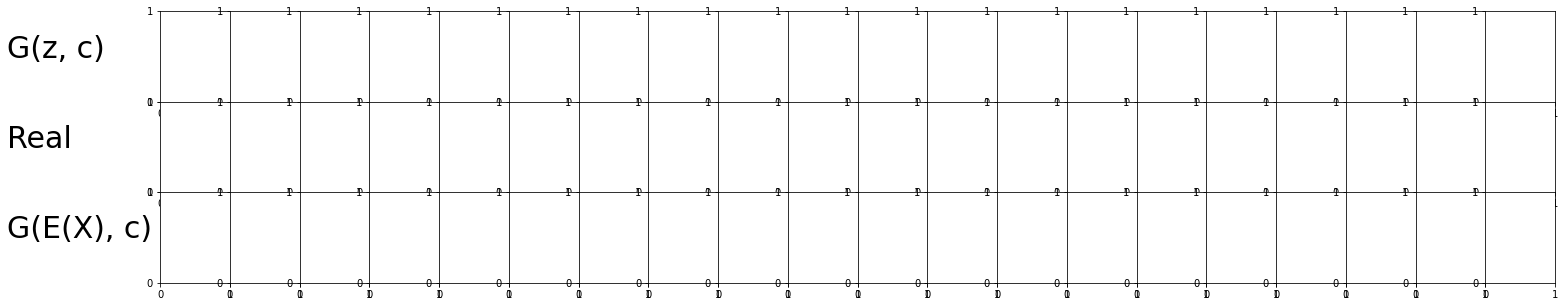

In [ ]:
#save final results
n_show = 20
D.eval()
E.eval()
G.eval()

fig, ax = plt.subplots(3, n_show, figsize=(25,5))
fig.subplots_adjust(wspace=0.0, hspace=0)
plt.rcParams.update({'font.size': 30})
fig.text(0.04, 0.75, 'G(z, c)', ha='left')
fig.text(0.04, 0.5, 'Real', ha='left')
fig.text(0.04, 0.25, 'G(E(X), c)', ha='left')


with torch.no_grad(): 
    for i in range(10):
        real = images[labels == i][:2]
        
        c = torch.zeros(2, 6, dtype=torch.float32).to(device)
        c[torch.arange(2), i] = 1
        z = 2 * torch.rand(2, 50) - 1
        z = z.to(device)
        
        gener = G(z, c).reshape(2, 28, 28).cpu().numpy()
        recon = G(E(real), c).reshape(2, 28, 28).cpu().numpy()
        real = real.reshape(2, 28, 28).cpu().numpy()
        
        ax[0, i].imshow(gener[0], cmap='gray')
        ax[0, i].axis('off')
        ax[0, i+10].imshow(gener[1], cmap='gray')
        ax[0, i+10].axis('off')
        
        ax[1, i].imshow(real[0], cmap='gray')
        ax[1, i].axis('off')
        ax[1, i+10].imshow(real[1], cmap='gray')
        ax[1, i+10].axis('off')
        
        ax[2, i].imshow(recon[0], cmap='gray')
        ax[2, i].axis('off')
        ax[2, i+10].imshow(recon[1], cmap='gray')
        ax[2, i+10].axis('off')
        
    plt.savefig('.\plots\Final_Results_CBiGAN.png')

# t-SNE

In [ ]:
E.eval()
X_test = mnist_test.dataset.data.float().reshape(-1, 28 * 28).to(device)
y_test = mnist_test.dataset.targets.numpy()
labels = np.unique(y_test)

with torch.no_grad():
    EX_test = E(X_test).cpu().numpy()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, learning_rate=70, n_iter=2000, n_iter_without_progress=400, verbose=1)
EX2D = tsne.fit_transform(EX_test)

In [ ]:
plt.figure(figsize=(10,15))
plt.rcParams.update({'font.size': 30})
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightblue', 'orange', 'gray']

for i, c in zip(labels, colors):
    idx = y_test==i
    plt.scatter(EX2D[y_test==i, 0], EX2D[y_test==i,1], c=c, label=str(i))
    
plt.legend(bbox_to_anchor=(-0.1, 0.55), loc=2, borderaxespad=0)
plt.axis('off')
plt.savefig(r'.\plots\tSNE_CBiGAN.png')

# 1NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train, y_train = mnist_train.dataset.data.float().reshape(-1, 28 * 28).to(device), mnist_train.dataset.targets.numpy()
X_test, y_test = mnist_test.dataset.data.float().reshape(-1, 28 * 28).to(device), mnist_test.dataset.targets.numpy()

E.eval()

with torch.no_grad():
    EX_train = E(X_train).cpu().numpy()
    EX_test = E(X_test).cpu().numpy()

KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(EX_train, y_train)
predictions = KNN.predict(EX_test)
accuracy = np.sum(predictions == y_test) / len(y_test)
print('Accuracy {:.2f}%'.format(accuracy*100))